In [1]:
import numpy as np
import os
import pickle

import matplotlib.pyplot as plt

In [36]:
def load_jets(root_dir, filename):
    """Load truth binary trees"""
    #root_dir = "../data/"
    filename = os.path.join(root_dir, filename)
    with open(filename + ".pkl", "rb") as fd:
        Truth= pickle.load(fd, encoding='latin-1')
    return Truth

In [3]:
gt_trees = load_jets("data", "ginkgo_5000_jets_no_cuts_lambda_21_pt_min_36_jetp_400")  # My test file

## Load leaf-based grid results

In [ ]:
train_leaves_ix = [len(x["leaves"])-1 for x in gt_trees[:1000]]  # only use the first 1000 leaves

In [31]:
#fig, ax = plt.subplots(nrows=1, ncols=1)
#fig.set_size_inches(8,8)

n_cuts = 40
n_lambda = 40

cut_vals = np.linspace(4, 90, n_cuts)
lambda_vals = np.linspace(1e-1, 5, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

max_LL = -np.inf
mle_params = None

likelihood_surface = np.zeros((n_lambda, n_cuts))

for i in range(n_cuts):
    for j in range(n_lambda):
        model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}
        
        jet_list = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_8000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
            int(grid_lambda[j,i])*1000,
            int(grid_cut[j,i]),
            j,
            i))
        
        num_leaves = [len(x["leaves"]) for x in jet_list]
        log_dist = np.log(np.histogram(num_leaves, bins=np.arange(1,50), density=True)[0])
        
        likelihood = 0
        for ix in train_leaves_ix:
            likelihood += log_dist[ix]
        
        likelihood_surface[j,i] = likelihood
        if likelihood > max_LL:
            max_LL = likelihood
            mle_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

<ipython-input-31-2d18afd93441>:27: RuntimeWarning: divide by zero encountered in log
  log_dist = np.log(np.histogram(num_leaves, bins=np.arange(1,50), density=True)[0])


In [32]:
np.save("data/likelihood_fit_on_leaves_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy", likelihood_surface)

## Load trellis grid results

In [ ]:
n_cuts = 40
n_lambda = 40
N_jets = 1000

cut_vals = np.linspace(4, 90, n_cuts)
#lambda_vals = np.round(np.exp(np.linspace(np.log(1e-3), np.log(5), n_lambda)), decimals=6)
lambda_vals = np.linspace(1e-1, 5, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

max_Z = -np.inf
mle_params = None
likelihood_surface = np.zeros((40,40))

outdir = "/scratch/mdd424/data/trellis"

for i in range(n_cuts):
    for j in range(n_lambda):
        model_params = {"delta_min": grid_cut[j,i], "lam": grid_lambda[j,i]}

        in_filename = os.path.join(outdir, "trellis_1000_jets_lambda_{:n}_ptcut_{:n}_{}_{}.pkl".format(
            int(1000*float(grid_lambda[j,i])),
            int(float(grid_cut[j,i])),
            j,
            i))
        with open(in_filename, "rb") as fd:
            results = pickle.load(fd, encoding='latin-1')
            
        avg_Z = np.sum(results["Z"])
        likelihood_surface[j,i] = avg_Z
        if avg_Z > max_Z:
            max_Z = avg_Z
            mle_params = model_params

## Look at Results

In [7]:
n_cuts = 40
n_lambda = 40
N_jets = 1000

cut_vals = np.linspace(4, 90, n_cuts)
lambda_vals = np.linspace(1e-1, 5, n_lambda)
grid_cut, grid_lambda = np.meshgrid(cut_vals, lambda_vals)

### Load results from fitting just based on leaves

In [8]:
leaf_likelihood_surface = np.load("data/likelihood_fit_on_leaves_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [9]:
leaf_likelihood_surface[np.isnan(leaf_likelihood_surface)] = -np.inf
mle_leaf_coords = np.unravel_index(np.argmax(leaf_likelihood_surface, axis=None), leaf_likelihood_surface.shape)
mle_leaf_coords

(21, 11)

In [10]:
lambda_vals[mle_leaf_coords[0]], cut_vals[mle_leaf_coords[1]]

(2.7384615384615385, 28.25641025641026)

### Load results from Trellis MLE fit

In [11]:
likelihood_surface = np.load("data/likelihood_fit_trellis_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [26]:
mle_coords = np.unravel_index(np.argmax(likelihood_surface[~np.isnan(likelihood_surface)], axis=None), likelihood_surface.shape)
mle_coords

(7, 13)

In [13]:
lambda_vals[mle_coords[0]], cut_vals[mle_coords[1]]

(0.9794871794871794, 32.66666666666667)

### Load results from Trellis MAP MLE fit

In [51]:
likelihood_map_surface = np.load("data/likelihood_fit_trellis_map_ginkgo_1000_jets_lambda_21_pt_min_36_jetp_400.npy")

In [52]:
mle_map_coords = np.unravel_index(np.argmax(likelihood_map_surface[~np.isnan(likelihood_map_surface)], axis=None), likelihood_map_surface.shape)
mle_map_coords

(21, 5)

In [54]:
lambda_vals[mle_map_coords[0]], cut_vals[mle_map_coords[1]]

(2.7384615384615385, 15.025641025641026)

### Get truth results

In [15]:
truth_bin = [None, None]
for ix, x in enumerate(cut_vals >= 36):
    if x.item() is True:
        truth_bin[0] = ix-1
        break
        
for ix, x in enumerate(lambda_vals >= 2.1):
    if x.item() is True:
        truth_bin[1] = ix-1
        break
        
print(truth_bin)

[14, 15]


In [16]:
lambda_vals[truth_bin[1]], cut_vals[truth_bin[0]]

(1.9846153846153847, 34.871794871794876)

### Plot results for Trellis Likelihoods

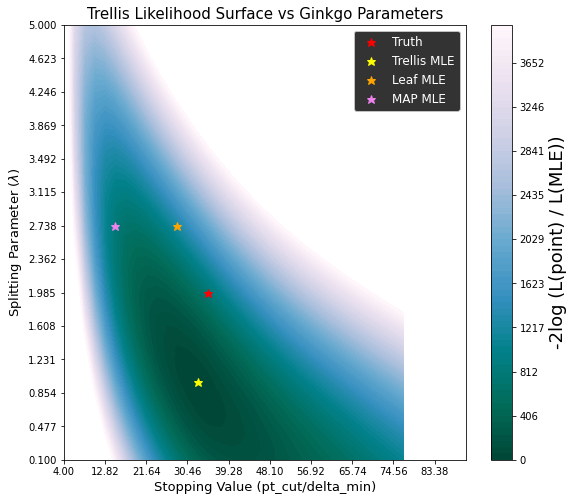

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(likelihood_surface-likelihood_surface[mle_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-2, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Plot results for Trellis MAP Likelihood

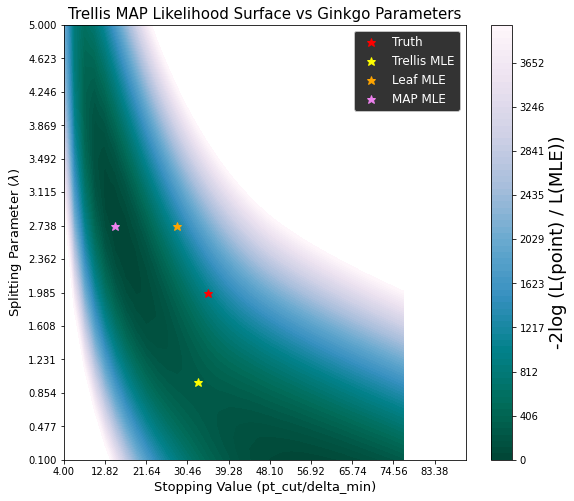

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(likelihood_map_surface-likelihood_map_surface[mle_map_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-2, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Trellis MAP Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Plot results for Leaf-based Likelihoods

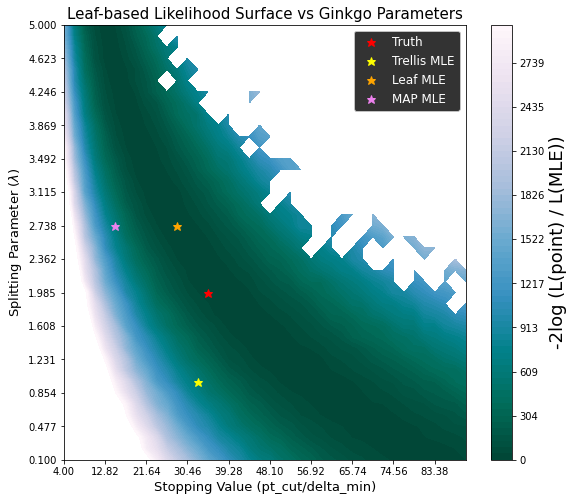

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(9,8)

Z = -2*(leaf_likelihood_surface-leaf_likelihood_surface[mle_leaf_coords])

# Boost the upper limit to avoid truncation errors.
levels = -2*np.flip(np.linspace(-1.5, 0, 70))*1000

cset1 = ax.contourf(grid_cut, grid_lambda, Z,
                    levels, cmap="PuBuGn_r")
cb = fig.colorbar(cset1, ax=ax)
cb.set_label(label="-2log (L(point) / L(MLE))", size=18)

ax.plot(cut_vals[truth_bin[0]], lambda_vals[truth_bin[1]], "*", color="red", markersize=9, label="Truth")
ax.plot(cut_vals[mle_coords[1]], lambda_vals[mle_coords[0]], "*", color="yellow", markersize=9, label="Trellis MLE")
ax.plot(cut_vals[mle_leaf_coords[1]], lambda_vals[mle_leaf_coords[0]], "*", color="orange", markersize=9, label="Leaf MLE")
ax.plot(cut_vals[mle_map_coords[1]], lambda_vals[mle_map_coords[0]], "*", color="violet", markersize=9, label="MAP MLE")

ax.legend(labelcolor="white", facecolor="black", fontsize="large")

ax.set_title("Leaf-based Likelihood Surface vs Ginkgo Parameters", size=15)
ax.set_xlabel("Stopping Value (pt_cut/delta_min)", size=13)
ax.set_ylabel("Splitting Parameter ($\lambda$)", size=13)
#ax.set_yscale("log")
ax.set_xticks(cut_vals[::4])
ax.set_yticks(lambda_vals[::3]);

### Chi-squared values

In [19]:
-2*(likelihood_surface[truth_bin[1], truth_bin[0]] - likelihood_surface[mle_coords])

769.1110677137112

In [64]:
-2*(likelihood_map_surface[truth_bin[1], truth_bin[0]] - likelihood_map_surface[mle_map_coords])

995.0461491430906

In [35]:
-2*(leaf_likelihood_surface[truth_bin[1], truth_bin[0]] - leaf_likelihood_surface[mle_leaf_coords])

20.263532986095925

## Look at the distribution of number of leaves at the three points

In [37]:
trellis_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_8000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
    int(grid_lambda[mle_coords])*1000,
    int(grid_cut[mle_coords]),
    mle_coords[0],
    mle_coords[1]))

In [38]:
leaf_mle_jets = load_jets("/scratch/mdd424/data/ginkgo", "ginkgo_8000_jets_jetp_400_lambda_{:n}_ptcut_{:n}_{}_{}".format(
    int(grid_lambda[mle_leaf_coords])*1000,
    int(grid_cut[mle_leaf_coords]),
    mle_leaf_coords[0],
    mle_leaf_coords[1]))

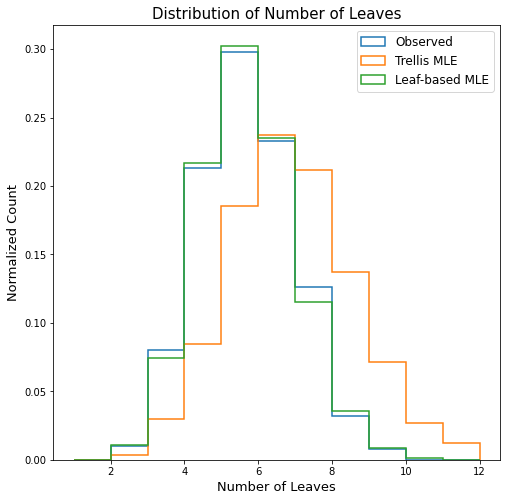

In [48]:
truth_num_leaves = [len(x["leaves"]) for x in gt_trees[:1000]]
trellis_num_leaves = [len(x["leaves"]) for x in trellis_mle_jets]
leaf_num_leaves = [len(x["leaves"]) for x in leaf_mle_jets]

#mle_num_leaves = [len(x["leaves"]) for x in mle_gt_trees]
#print(np.min(mle_num_leaves), np.max(mle_num_leaves))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,8)

ax.hist(truth_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Observed")
ax.hist(trellis_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5,  density=True, label="Trellis MLE")
ax.hist(leaf_num_leaves, bins=np.arange(1,13), histtype="step", linewidth=1.5, density=True, label="Leaf-based MLE")

ax.set_xlabel("Number of Leaves", size=13)
ax.set_ylabel("Normalized Count", size=13)
ax.set_title("Distribution of Number of Leaves", size=15)
ax.legend(fontsize="large")

In [50]:
np.mean(truth_num_leaves), np.mean(trellis_num_leaves)

(5.21, 6.419625)